# Loading the data

In [114]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import string
import bz2
import re
from collections import Counter
import nltk
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = bz2.BZ2File("/content/drive/MyDrive/python homework/test.ft.txt.bz2")
data = data.readlines()
print("Number of  reviews: " + str(len(data)))

Number of  reviews: 400000


In [4]:
sample_size = 200000 #Using 200,000 reviews from test set
data = [x.decode('utf-8') for x in data[:sample_size]]
print(data[0])

__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"



# Exploring and processing the data

## Cleaning the data

__label__2 is positive and __label__1 is negative

In [5]:
df = pd.DataFrame({'text':data})
df['target'] = df.text.apply(lambda x: 1 if '__label__2' in x.split() else 0)
# clean target from text
df['text'] = df.text.apply(lambda x: re.sub(r'__label__\d','',x).strip())
# turn urls into a <url> token
df['text'] = df.text.apply(lambda x: re.sub(r'([^ ]+(?<=\.[a-z]{3}))', '<url>',x))

In [6]:
# Too many positives so unbalanced dataset
df.value_counts('target')

target
1    100565
0     99435
dtype: int64

In [7]:
# Let's balance it by gettign as many positives as there are negatives
df_negatives = df[df.target == 0]
df_positives = df[df.target == 1].sample(df_negatives.shape[0], random_state = 1)
df_balanced = pd.concat([df_negatives, df_positives])

In [8]:
df_balanced.value_counts('target')

target
1    99435
0    99435
dtype: int64

## How are review text sizes distributed?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


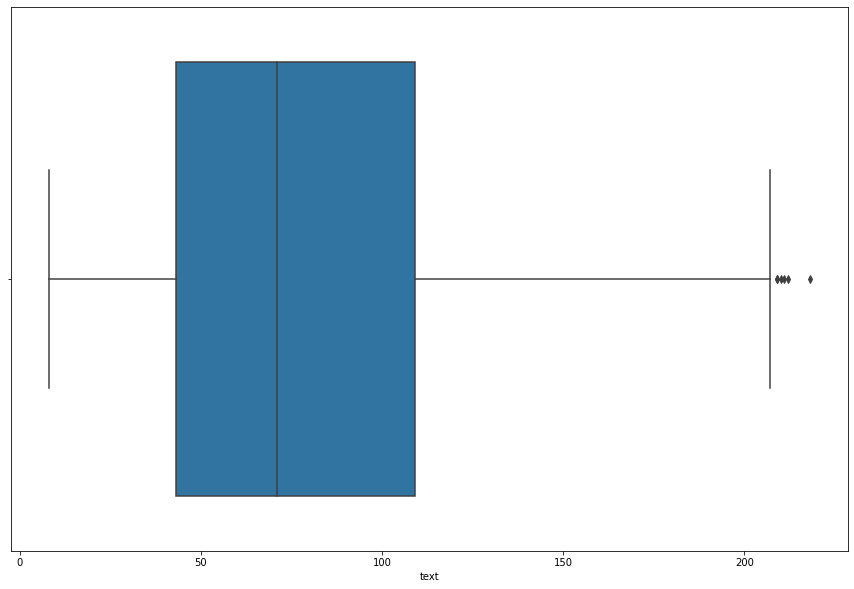

In [9]:
plt.figure(figsize=(15,10))
sns.boxplot(df_balanced.text.apply(lambda x: len(x.split())))

Okay, now we are ready to pre-process this text so that we can use it in our LSTM network.

In [10]:
STOP_WORDS = set(stopwords.words('english')) 

# TODO improve with more filters
def preprocess_text(raw_text):
      global STOP_WORDS
      word_list = []
      for word in raw_text.lower().strip().split():
            word = re.sub(r'\d', '', word) # removes digits
            word = re.sub(r"[^\w\s]", '', word) # removes all non word chars
            if word not in STOP_WORDS and word != '':
                word_list.append(word)

      return ' '.join(word_list)

df_balanced['cleaned_text'] = df_balanced.text.apply(lambda x: preprocess_text(x))

In [11]:
df_balanced.head()

,text,target,cleaned_text
2,Batteries died within a year ...: I bought thi...,0,batteries died within year bought charger jul ...
5,DVD Player crapped out after one year: I also ...,0,dvd player crapped one year also began incorre...
6,"Incorrect Disc: I love the style of this, but ...",0,incorrect disc love style couple years dvd giv...
7,DVD menu select problems: I cannot scroll thro...,0,dvd menu select problems cannot scroll dvd men...
9,"Not an ""ultimate guide"": Firstly,I enjoyed the...",0,ultimate guide firstlyi enjoyed format tone bo...


We check distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


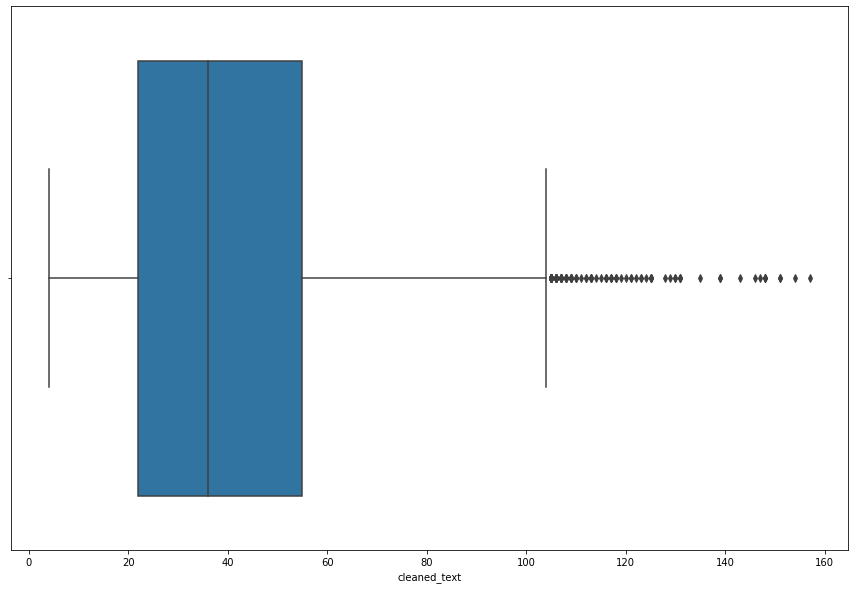

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot(df_balanced.cleaned_text.apply(lambda x: len(x.split())))

In [13]:
df_balanced.cleaned_text.apply(lambda x: len(x.split())).describe()

count    198870.000000
mean         40.472972
std          21.956238
min           4.000000
25%          22.000000
50%          36.000000
75%          55.000000
max         157.000000
Name: cleaned_text, dtype: float64

## Creating vocab

Now that we already have the cleaned text we can go ahead and create a dictionary, so that we can use words as numbers.

In [14]:
all_words = [ w for s in df_balanced.cleaned_text.values.tolist() for w in s.split()]
words = Counter(all_words)

There seems to be many positive words, maybe classifier learn by lack of positive words or by a couple negative but at first glance it looks challenging.

In [15]:
words.most_common(30)

[('book', 107613),
 ('one', 74654),
 ('like', 58147),
 ('great', 57939),
 ('good', 56904),
 ('would', 45172),
 ('movie', 42563),
 ('read', 40128),
 ('get', 37120),
 ('time', 36364),
 ('dont', 34892),
 ('really', 32485),
 ('first', 28232),
 ('even', 27980),
 ('much', 27850),
 ('well', 27684),
 ('love', 26349),
 ('best', 24150),
 ('album', 23528),
 ('buy', 23493),
 ('cd', 23301),
 ('better', 22642),
 ('story', 21102),
 ('product', 21044),
 ('could', 20568),
 ('work', 20135),
 ('also', 20049),
 ('use', 20038),
 ('new', 19375),
 ('way', 19171)]

In [16]:
words = {k:v for k,v in words.items() if v > 1}
# Sorting on the basis of most common words
words = sorted(words, key = words.get, reverse = True)
words = ['_PAD', '_UNK'] + words

# Creating a dict
word_to_idx = { w : i for i,w in enumerate(words) }
idx_to_word = {v : k for k,v in word_to_idx.items()}

In [17]:
def process_sequence(text_sequence):
  global word_to_idx
  res = []
  for w in text_sequence:
    if w in word_to_idx:
      res.append(word_to_idx[w])
    else:
      res.append(1)
  return res

# Adding padding (Important note)

We are ready to created the training set:

In [18]:
X = [process_sequence(s.split()) for s in df_balanced.cleaned_text.values.tolist()]
y = df_balanced.target.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [19]:
# we get the longest sequences for train and we use this to pad both train and test
MAX_LEN = max([len(s) for s in  X_train])


'''
*What I learned:*
Commonly in RNN's, we take the final output or hidden state and use this to make a prediction (or do whatever task we are trying to do).
If we send a bunch of 0's to the RNN before taking the final output (i.e. 'post' padding as you describe), 
then the hidden state of the network at the final word in the sentence would likely get 'flushed out' to some extent by all the zero inputs that come after this word.
So intuitively, this might be why pre-padding is more popular/effective.
'''

X_train = pad_sequences(X_train, maxlen = MAX_LEN, padding = 'pre')
X_test = pad_sequences(X_test, maxlen = MAX_LEN, padding = 'pre')
y_train = np.array(y_train)
y_test = np.array(y_test)

In [20]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [21]:
batch_size = 512

train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle = True, batch_size = batch_size, drop_last = True)

# The model

So now we can go ahead and create and use our model!

We use some hyperparameters such as the vocab size, the hidden layer dimension, the number of layers and the dropout probability.

In [22]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first = True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size) # fully connected
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long() # cast to long tensor
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [23]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [24]:
vocab_size = len(word_to_idx) + 1
output_size = 1
embedding_dim = 400 # TODO: try 128 or 256
hidden_dim = 512 # TODO: try 256
n_layers = 2

model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(98123, 400)
  (lstm): LSTM(400, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [25]:
lr = 0.005
criterion = nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

## Training the model

We save the best model based on the loss function, mean ing that it will take as the best model the one with the smallest value of test_losses. 

That could also mean that the best model might not have the highest accuracy score, although the difference is small.

It will save the model as "best_LSTM_model.pt" in ghe shared drive folder.

We reach 89% of accuracy with 2 epochs.

In [26]:
epochs = 2
counter = 0
print_every = 50
clip = 5
test_loss_min = np.Inf

model.train() # model set to training mode

for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([e.data for e in h])
        model.zero_grad() # reset gradients 
        output, h = model(inputs, h) # forward propagation
        loss = criterion(output.squeeze(), labels.float()) # compute loss
        loss.backward() # backward propagation
        nn.utils.clip_grad_norm_(model.parameters(), clip) # regularization by clipping gradient
        optimizer.step() # apply gradients
        
        # METRICS:
        if counter%print_every == 0:
            test_h = model.init_hidden(batch_size)
            test_losses = []
            num_correct = 0
            model.eval()
            for inp, lab in test_loader:
                test_h = tuple([each.data for each in test_h])
                inp, lab = inp.to(device), lab.to(device)
                out, test_h = model(inp, test_h)
                test_loss = criterion(out.squeeze(), lab.float())
                test_losses.append(test_loss.item())

                # Compute acc
                pred = torch.round(out.squeeze()) #rounds the output to 0/1
                correct_tensor = pred.eq(lab.float().view_as(pred)) # calculate how many preds == labels
                correct = np.squeeze(correct_tensor.cpu().numpy()) # like np.ravel
                num_correct += np.sum(correct) # sums matches

            print("Test loss: {:.3f}".format(np.mean(test_losses)))
            test_acc = num_correct/len(test_loader.dataset)
            print("Test accuracy: {:.3f}%".format(test_acc*100))

                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Test Loss: {:.6f}".format(np.mean(test_losses)))
            if np.mean(test_losses) <= test_loss_min:
                torch.save(model.state_dict(), '/content/drive/MyDrive/python homework/best_LSTM_model.pt')
                print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min, np.mean(test_losses)))
                test_loss_min = np.mean(test_losses)

Test loss: 0.499
Test accuracy: 76.447%
Epoch: 1/2... Step: 50... Loss: 0.512610... Test Loss: 0.498585
Test loss decreased (inf --> 0.498585).  Saving model ...
Test loss: 0.419
Test accuracy: 80.949%
Epoch: 1/2... Step: 100... Loss: 0.382089... Test Loss: 0.419145
Test loss decreased (0.498585 --> 0.419145).  Saving model ...
Test loss: 0.320
Test accuracy: 86.057%
Epoch: 1/2... Step: 150... Loss: 0.300209... Test Loss: 0.320099
Test loss decreased (0.419145 --> 0.320099).  Saving model ...
Test loss: 0.296
Test accuracy: 87.731%
Epoch: 1/2... Step: 200... Loss: 0.296457... Test Loss: 0.296340
Test loss decreased (0.320099 --> 0.296340).  Saving model ...
Test loss: 0.275
Test accuracy: 88.672%
Epoch: 1/2... Step: 250... Loss: 0.301570... Test Loss: 0.275069
Test loss decreased (0.296340 --> 0.275069).  Saving model ...
Test loss: 0.274
Test accuracy: 89.040%
Epoch: 2/2... Step: 300... Loss: 0.200748... Test Loss: 0.274281
Test loss decreased (0.275069 --> 0.274281).  Saving model ..

# Testing the model and loading it from Drive

we can load the best LSTM model previously trained and saved. 

In [27]:
model.load_state_dict(torch.load('/content/drive/MyDrive/python homework/best_LSTM_model.pt'))
model.eval()
print(model)

SentimentLSTM(
  (embedding): Embedding(98123, 400)
  (lstm): LSTM(400, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [28]:
def process_custom(text):
  global MAX_LEN
  sequence = process_sequence(text.split())
  # quick pre-padding
  sequence = [0]*(MAX_LEN - len(sequence)) + sequence
  return torch.unsqueeze(torch.from_numpy(np.array(sequence)), 0)

In [56]:
def make_prediction(review, show_tensfor_shape=False):

  label_dict={0:"negative", 1:"positive"}

  custom_review_tensor = process_custom(review)
  test_h = model.init_hidden(1)
  out, test_h = model(custom_review_tensor.to(device), test_h)

  if show_tensfor_shape == True:
    print(custom_review_tensor)
  
  rounded_pred = torch.round(out)

  print("Exact calculation:", out)
  print("\nPrediction: {}. Representing a {} review.".format(int(rounded_pred), label_dict[int(rounded_pred)]))
  #return rounded_pred

## Testing multiple types of reviews

### Negative reviews

In [57]:
negative_review = 'This product is the worst! I would not recommend buying it at all. A fucking mess.'

make_prediction(negative_review)

Exact calculation: tensor([0.1534], device='cuda:0', grad_fn=<SelectBackward>)

Prediction: 0. Representing a negative review.


### Positive rewiews

In [59]:
positive_review = 'The product is of good quality overall. However, some things could be improved. But it is a nice buy.'

# Showing the encoded, padded review as a tensor. "0" represents PADDING.
make_prediction(positive_review, True)

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  25,
           1,   1,   6,  63,   1,   1,   1, 139,  26,   1,   1,   1,   1,   1,
           1, 105,   1]])
Exact calculation: tensor([0.8077], device='cuda:0', grad_fn=<SelectBackward>)

Prediction: 1. Representi

### Similar to neutral or confusing reviews
If we test with more confusing or neutral reviews we can see how the model is able to middle out the calculated prediction to around 0.5 (In the middle between positive and negative).

In [62]:
neutral_review = 'The latest marvel comic was not as good as I expected, however this movie ended up being much better than I thought. You should give it a try.'

# See that the calculated prediction is around 0.45 and 0.5
make_prediction(neutral_review)

Exact calculation: tensor([0.4668], device='cuda:0', grad_fn=<SelectBackward>)

Prediction: 0. Representing a negative review.


# Confusion matrix

In [84]:
# The data as pytorch tensors, including the reviews and the labels
print(test_data.tensors)

# Only the labels 
print("\n\nOnly the labels:", test_data.tensors[1])

(tensor([[    0,     0,     0,  ...,    66,  1009,  1247],
        [    0,     0,     0,  ...,   436,     6,     3],
        [    0,     0,     0,  ...,  3225,   182,    58],
        ...,
        [    0,     0,     0,  ...,    74,   129,   452],
        [    0,     0,     0,  ..., 21885, 27547,  2507],
        [    0,     0,     0,  ...,   155,   660,    77]], dtype=torch.int32), tensor([1, 1, 1,  ..., 0, 0, 0]))


Only the labels: tensor([1, 1, 1,  ..., 0, 0, 0])


In [98]:
test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)
y_pred = []
y_true = []

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1´
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    y_pred.extend(pred.tolist())
    y_true.extend(labels.tolist())
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.256
Test accuracy: 89.515%


In [111]:
print(len(y_true), len(y_pred))

49664 49664


In [108]:
cm = confusion_matrix(y_true, y_pred)
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[22227,  2739],
       [ 2420, 22278]])

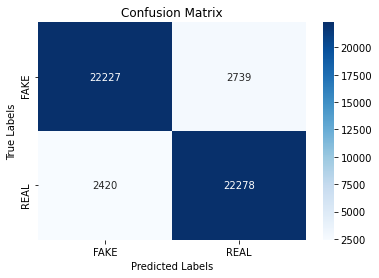

In [131]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

print()

# Evaluation
We will use the F1-score evaluation method using scikit learn, as well as calculating it manually as we learned in the labs.

## Scikit-learn classification report

In [132]:
print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

Classification Report:
              precision    recall  f1-score   support

           1     0.8905    0.9020    0.8962     24698
           0     0.9018    0.8903    0.8960     24966

    accuracy                         0.8961     49664
   macro avg     0.8962    0.8962    0.8961     49664
weighted avg     0.8962    0.8961    0.8961     49664



## Own manual classification report

In [137]:
def f_score(gold, predicted):
    from sklearn.metrics import precision_recall_fscore_support
    d = {}
    cm=confusion_matrix(gold,predicted)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
    f = (2 * PPV * TPR) / (PPV + TPR)
    #print(TP, FP, FN)
    #print(TPR, PPV)
    micro = precision_recall_fscore_support(gold, predicted, average='micro')
    macro = precision_recall_fscore_support(gold, predicted, average='macro')
    for i in range(2):
      #print(i)
      d[i]= {'tp':TP[i], 'fp':FP[i], 'fn':FN[i], 'precision': PPV[i], 'recall': TPR[i], 'f': f[i]}
    
    d['MICRO AVG'] = {'precision': micro[0], 'recall': micro[1], 'f': micro[2]}
    d['MACRO AVG'] = {'precision': macro[0], 'recall': macro[1], 'f': macro[2]}

    return d

In [138]:
f_score(y_true, y_pred)

{0: {'f': 0.8960151573176386,
  'fn': 2739,
  'fp': 2420,
  'precision': 0.9018136081470361,
  'recall': 0.8902907954818553,
  'tp': 22227},
 1: {'f': 0.8962285024640451,
  'fn': 2420,
  'fp': 2739,
  'precision': 0.8905144501738818,
  'recall': 0.9020163575998057,
  'tp': 22278},
 'MACRO AVG': {'f': 0.8961218298908418,
  'precision': 0.8961640291604589,
  'recall': 0.8961535765408305},
 'MICRO AVG': {'f': 0.8961219394329897,
  'precision': 0.8961219394329897,
  'recall': 0.8961219394329897}}

# Extra: trying a Machine Learning model
## RandomForestClassifier

In [146]:
X_train

array([[    0,     0,     0, ...,   187,  6088,   156],
       [    0,     0,     0, ..., 11687, 33563,     3],
       [    0,     0,     0, ...,  1019,  3085,   623],
       ...,
       [    0,     0,     0, ...,  7010,  7102,   149],
       [    0,     0,     0, ...,     8,   578,   492],
       [    0,     0,     0, ...,    21,   655, 84590]], dtype=int32)

In [156]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier

from wordcloud import STOPWORDS

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
stopwords = set(STOPWORDS)
stopwords.remove("not")


# df_balanced.cleaned_text

split = df_balanced[["cleaned_text" , "target"]]
train_nb =split.sample(frac=0.8,random_state=1)
test_nb =split.drop(train_nb.index)

count_vect = CountVectorizer(min_df=2 ,stop_words=stopwords , ngram_range=(1,2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train_nb["cleaned_text"])        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


X_new_counts = count_vect.transform(test_nb["cleaned_text"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [159]:
from sklearn.naive_bayes import MultinomialNB

prediction =  {}
model1 = MultinomialNB().fit(X_train_tfidf , train_nb["target"])
prediction['Multinomial'] = model1.predict_proba(X_test_tfidf)[:,1]
print("Multinomial Accuracy : {}".format(model1.score(X_test_tfidf , test_nb["target"])))

Multinomial Accuracy : 0.8792678634283703
